# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import torchvision.transforms as transforms
import argparse

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.0 MB/s eta 0:00:00


device(type='cpu')

# Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pwd
%cd /content/drive/MyDrive/Semantic_segmentation_dataset/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
/content/drive/MyDrive/Semantic_segmentation_dataset


In [ ]:
!pip install dataloader

In [ ]:
!ls /usr/local/lib/python3.10/dist-packages/dataloader

dataloader.py  datatest.py  __init__.py  __pycache__  termcolor.py


In [ ]:
!grep -r 'import' /usr/local/lib/python3.10/dist-packages/dataloader

/usr/local/lib/python3.10/dist-packages/dataloader/termcolor.py:from __future__ import print_function
/usr/local/lib/python3.10/dist-packages/dataloader/termcolor.py:import os
/usr/local/lib/python3.10/dist-packages/dataloader/__init__.py:from dataloader import read_data_sets
/usr/local/lib/python3.10/dist-packages/dataloader/datatest.py:import dataloader
/usr/local/lib/python3.10/dist-packages/dataloader/datatest.py:import argparse
/usr/local/lib/python3.10/dist-packages/dataloader/dataloader.py:import struct
/usr/local/lib/python3.10/dist-packages/dataloader/dataloader.py:import numpy
/usr/local/lib/python3.10/dist-packages/dataloader/dataloader.py:import scipy.io
/usr/local/lib/python3.10/dist-packages/dataloader/dataloader.py:import os
/usr/local/lib/python3.10/dist-packages/dataloader/dataloader.py:import scipy.sparse as sps
/usr/local/lib/python3.10/dist-packages/dataloader/dataloader.py:import termcolor as tc
/usr/local/lib/python3.10/dist-packages/dataloader/dataloader.py:def i

In [ ]:
!find /usr/local/lib/python3.10/dist-packages/dataloader -name 'read_data_sets.py'

In [ ]:

from dataloader import segDataset

ImportError: cannot import name 'read_data_sets' from partially initialized module 'dataloader' (most likely due to a circular import) (/usr/local/lib/python3.10/dist-packages/dataloader/__init__.py)

In [ ]:

def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data', type=str, default='/content/drive/MyDrive/aerial_UAE/Semantic segmentation dataset', help='path to your dataset')
    parser.add_argument('--num_epochs', type=int, default=100, help='dnumber of epochs')
    parser.add_argument('--batch', type=int, default=4, help='batch size')
    parser.add_argument('--loss', type=str, default='focalloss', help='focalloss | iouloss | crossentropy')
    args = parser.parse_args(args=[])
    return args


In [ ]:
    args = get_args()
    N_EPOCHS = args.num_epochs
    BACH_SIZE = args.batch

    color_shift = transforms.ColorJitter(.1,.1,.1,.1)
    blurriness = transforms.GaussianBlur(3, sigma=(0.1, 2.0))

    t = transforms.Compose([color_shift, blurriness])
    dataset = segDataset(args.data, training = True, transform= t)

    print('Number of data : '+ str(len(dataset)))

    test_num = int(0.1 * len(dataset))

    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len(dataset)-test_num, test_num], generator=torch.Generator().manual_seed(101))

    dataset1 = segDataset(args.data, training = False)
    _, test_dataset = torch.utils.data.random_split(dataset1, [len(dataset1)-test_num, test_num], generator=torch.Generator().manual_seed(101))
    N_DATA, N_VAL, N_TEST = len(train_dataset),len(val_dataset), len(test_dataset)
    print(f'train data : {N_DATA}, val data : {N_VAL}, test data : {N_TEST}')

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BACH_SIZE, shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BACH_SIZE, shuffle=False, num_workers=1)
    #test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)



Number of data : 72
train data : 65, val data : 7, test data : 7


# Dataset

Image Size (644, 797, 3)
Mask Size (644, 797, 3)


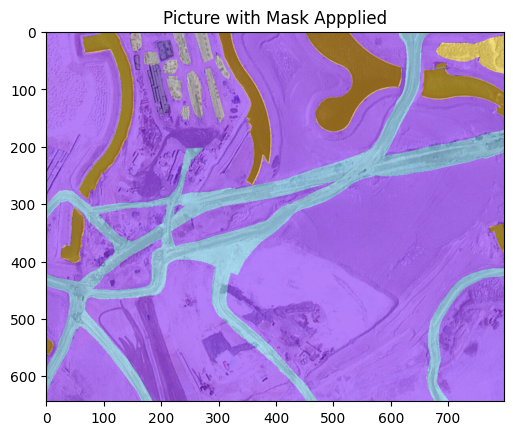

In [ ]:
img = cv2.imread('/content/drive/MyDrive/aerial_UAE/Semantic segmentation dataset/Tile 1/images/image_part_001.jpg')
mask = Image.open('/content/drive/MyDrive/aerial_UAE/Semantic segmentation dataset/Tile 1/masks/image_part_001.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

# Model

In [ ]:
#model = smp.DeepLabV3Plus('efficientnet-b7', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5)# decoder_channels=[256, 128, 64, 32, 16])

In [ ]:
model = smp.UnetPlusPlus('mobilenet_v2', encoder_weights='imagenet', classes=6, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16], in_channels=3)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 218MB/s]


In [ ]:
#model

# Training

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    #torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i,data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data



            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)


            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            #print(image.shape, output.shape, mask.shape)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data


                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
#torch.cuda.empty_cache()
max_lr = 1e-3
epoch = 5
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.096 
Epoch:1/5.. Train Loss: 1.625.. Val Loss: 1.096.. Train mIoU:0.176.. Val mIoU: 0.284.. Train Acc:0.387.. Val Acc:0.687.. Time: 10.23m


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 1.096 >> 0.950 
Epoch:2/5.. Train Loss: 1.088.. Val Loss: 0.950.. Train mIoU:0.327.. Val mIoU: 0.338.. Train Acc:0.662.. Val Acc:0.704.. Time: 10.14m


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.950 >> 0.729 
Epoch:3/5.. Train Loss: 0.920.. Val Loss: 0.729.. Train mIoU:0.326.. Val mIoU: 0.350.. Train Acc:0.700.. Val Acc:0.762.. Time: 10.36m


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:4/5.. Train Loss: 0.873.. Val Loss: 0.884.. Train mIoU:0.374.. Val mIoU: 0.349.. Train Acc:0.705.. Val Acc:0.667.. Time: 10.16m


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.884 >> 0.683 
saving model...
Epoch:5/5.. Train Loss: 0.781.. Val Loss: 0.683.. Train mIoU:0.395.. Val mIoU: 0.442.. Train Acc:0.747.. Val Acc:0.792.. Time: 10.24m
Total time: 51.13 m


In [ ]:
torch.save(model, 'UnetPlusPlus_resnet50.pt')

In [ ]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

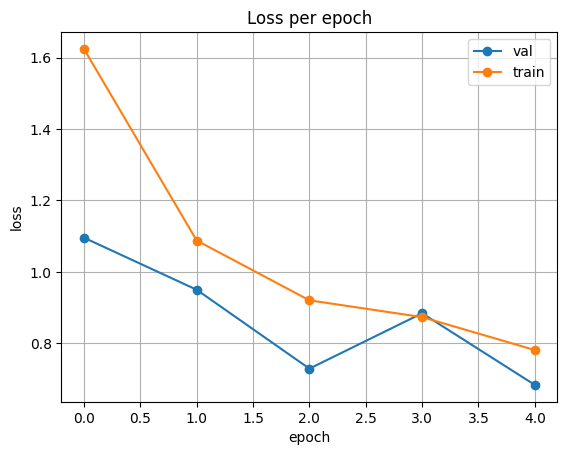

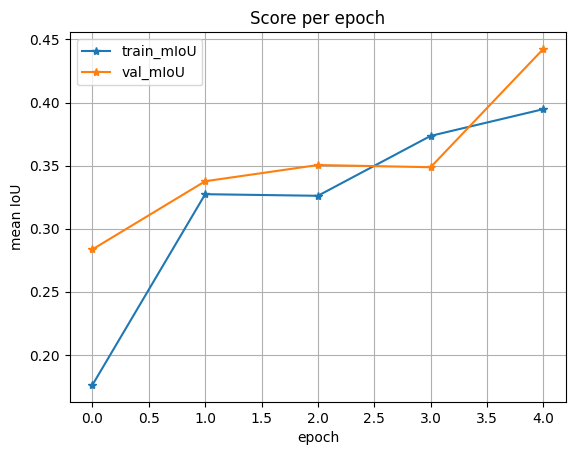

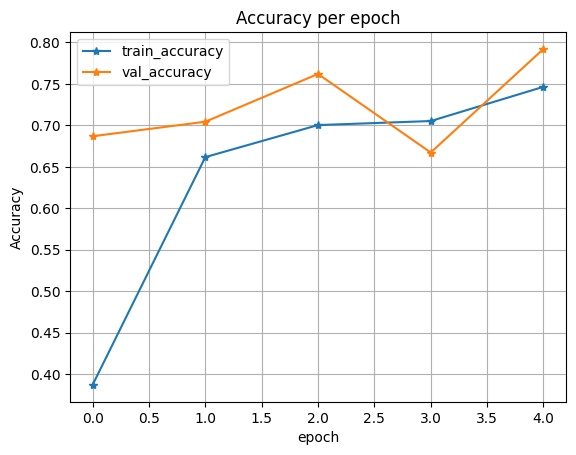

In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)

# Evaluation

## Result

In [ ]:
def predict_image_mask_miou(model, image, mask):
    model.eval()
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
def predict_image_mask_pixel(model, image, mask):
    model.eval()
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [ ]:
test_set = test_dataset

In [ ]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [ ]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
import numpy as np


def calculate_metrics(true_mask, predicted_mask, num_labels):
    total_tp = 0
    total_fp = 0
    total_fn = 0


    for label in range(1, num_labels + 1):
        # Flatten the 2D masks to 1D arrays
        true_labels = true_mask.flatten()
        predicted_labels = predicted_mask.flatten()


       # Count true positives (TP), false positives (FP), and false negatives (FN) for the current label
        tp = np.sum((true_labels == label) & (predicted_labels == label))
        fp = np.sum((true_labels != label) & (predicted_labels == label))
        fn = np.sum((true_labels == label) & (predicted_labels != label))


       # Accumulate total true positives, false positives, and false negatives
        total_tp += tp
        total_fp += fp
        total_fn += fn


   # Calculate overall precision, recall, and F1 score
    overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
    overall_f1_score = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0.0


    return overall_precision, overall_recall, overall_f1_score


Overall Precision: 0.6729534585108956
Overall Recall: 0.6510076779751028
Overall F1 Score: 0.661798683265392


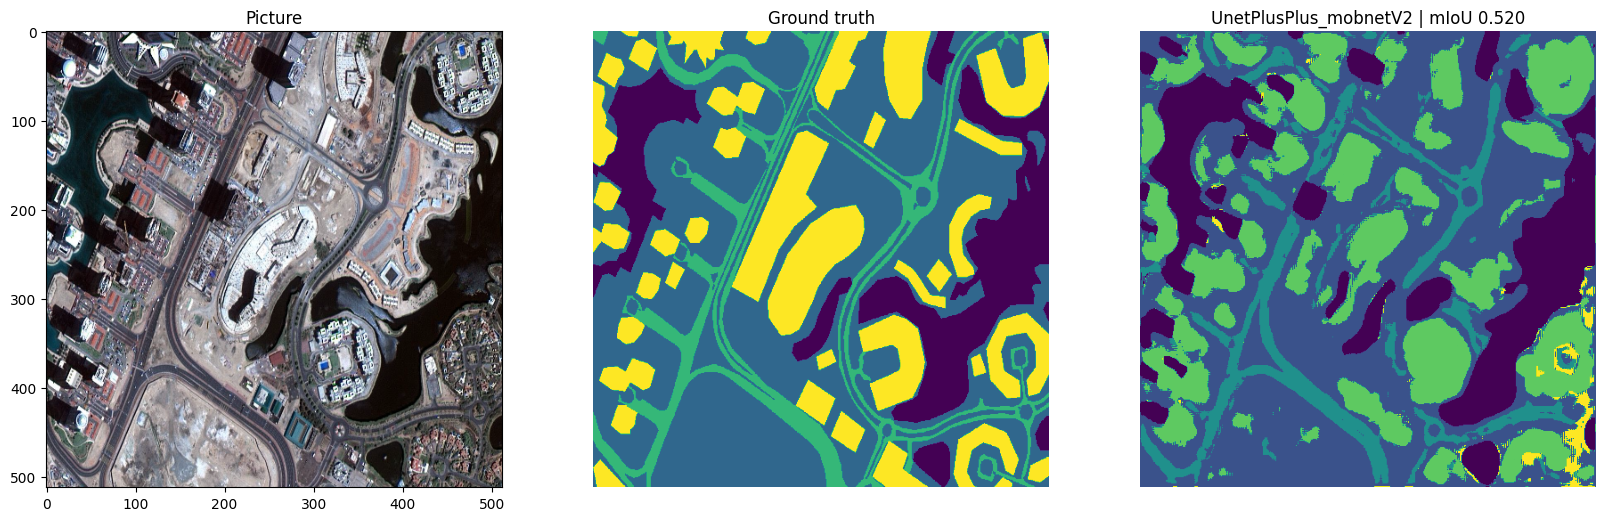

In [ ]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(np.moveaxis(image.numpy(), 0, -1))
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UnetPlusPlus_mobnetV2 | mIoU {:.3f}'.format(score))
ax3.set_axis_off()
overall_precision, overall_recall, overall_f1_score = calculate_metrics(np.array(mask), np.array(pred_mask), 5)
print(f'Overall Precision: {overall_precision}')
print(f'Overall Recall: {overall_recall}')
print(f'Overall F1 Score: {overall_f1_score}')

Overall Precision: 0.8188288853026039
Overall Recall: 0.8050458515092971
Overall F1 Score: 0.811878874971623


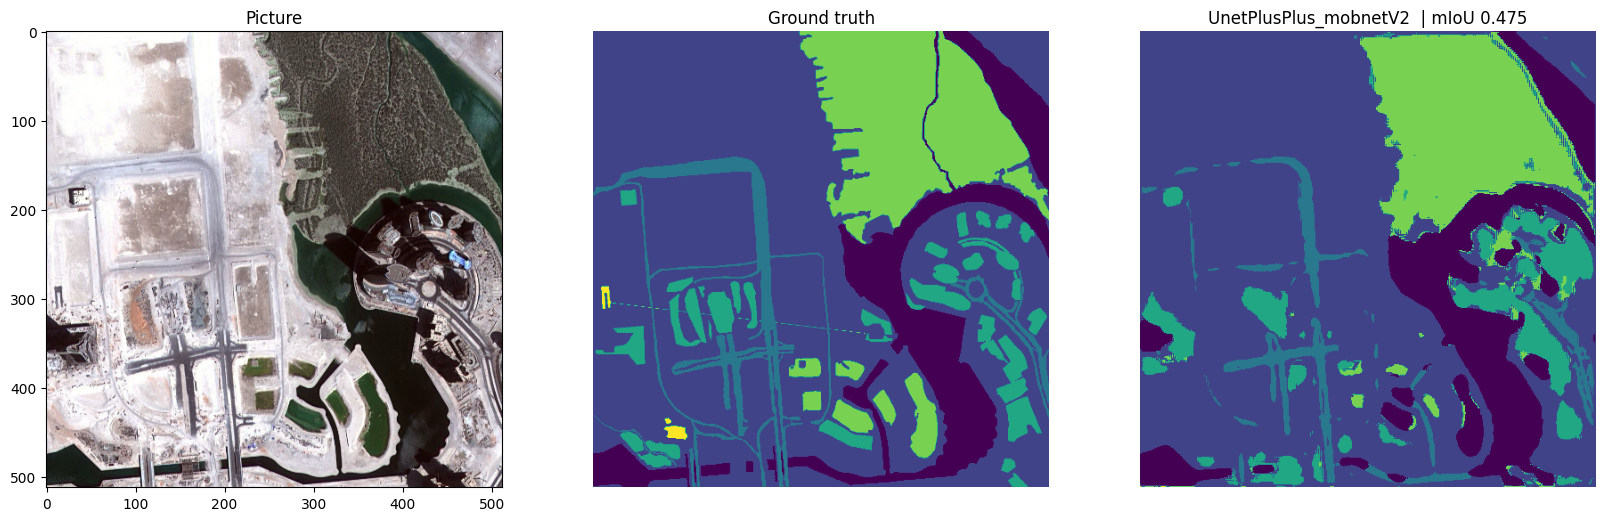

In [ ]:
image2, mask2 = test_set[5]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(np.moveaxis(image2.numpy(), 0, -1))
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UnetPlusPlus_mobnetV2  | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()
overall_precision, overall_recall, overall_f1_score = calculate_metrics(np.array(mask2), np.array(pred_mask2), 5)
print(f'Overall Precision: {overall_precision}')
print(f'Overall Recall: {overall_recall}')
print(f'Overall F1 Score: {overall_f1_score}')

Overall Precision: 0.6241990915129486
Overall Recall: 0.6532217674386473
Overall F1 Score: 0.6383807355804834


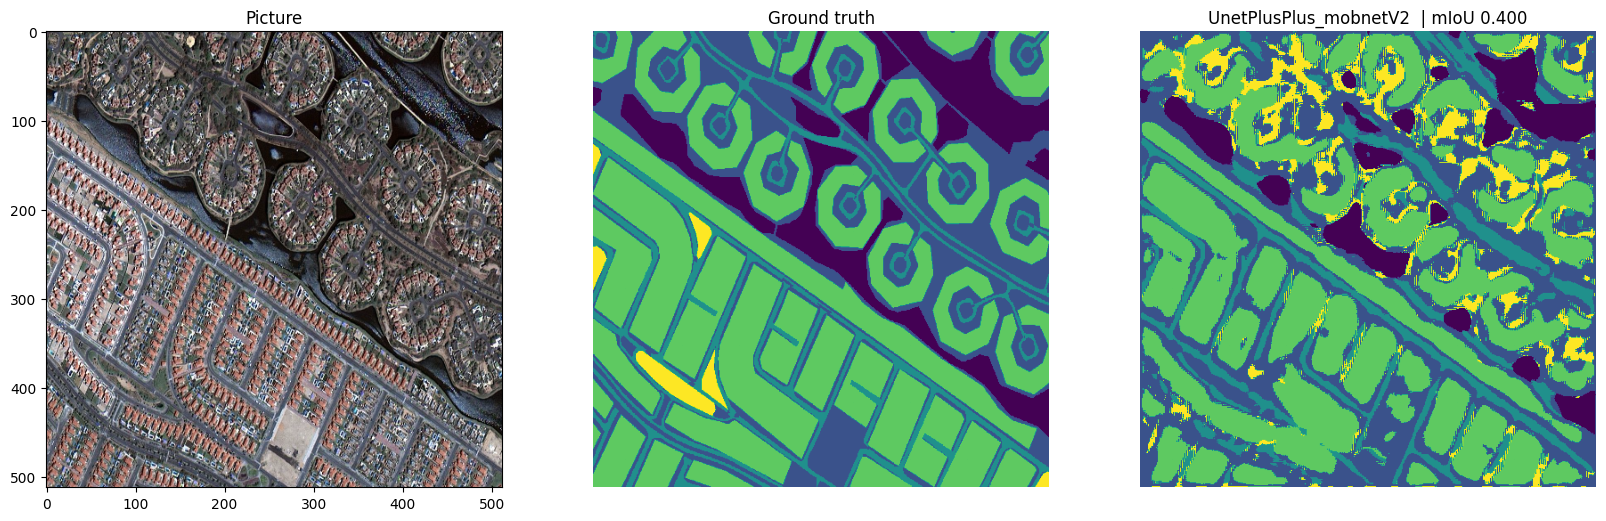

In [ ]:
image3, mask3 = test_set[2]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(np.moveaxis(image3.numpy(), 0, -1))
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UnetPlusPlus_mobnetV2  | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()
overall_precision, overall_recall, overall_f1_score = calculate_metrics(np.array(mask3), np.array(pred_mask3), 5)
print(f'Overall Precision: {overall_precision}')
print(f'Overall Recall: {overall_recall}')
print(f'Overall F1 Score: {overall_f1_score}')

Overall Precision: 0.8535145529706638
Overall Recall: 0.8482627868652344
Overall F1 Score: 0.8508805663175013


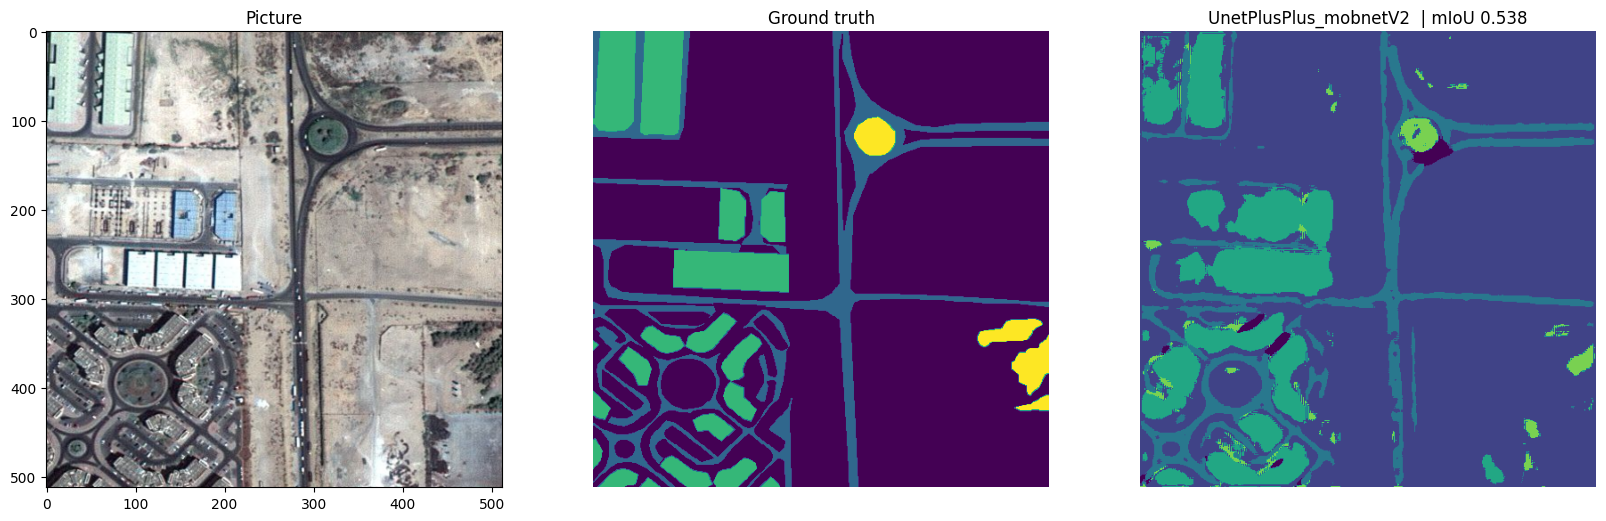

In [ ]:
image4, mask4 = test_set[4]
pred_mask4, score4 = predict_image_mask_miou(model, image4, mask4)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(np.moveaxis(image4.numpy(), 0, -1))
ax1.set_title('Picture');

ax2.imshow(mask4)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask4)
ax3.set_title('UnetPlusPlus_mobnetV2  | mIoU {:.3f}'.format(score4))
ax3.set_axis_off()
overall_precision, overall_recall, overall_f1_score = calculate_metrics(np.array(mask4), np.array(pred_mask4), 5)
print(f'Overall Precision: {overall_precision}')
print(f'Overall Recall: {overall_recall}')
print(f'Overall F1 Score: {overall_f1_score}')

In [ ]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.4180879887375578


In [ ]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.7864603315080915
